In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import os

In [2]:
# Directory containing the image paths
data_dir = '/kaggle/input/compcars/part'  # Update this with the correct path if needed

# Function to read image paths from text files
def read_image_paths(class_files, base_dir):
    image_paths = []
    labels = []
    for label, file_path in enumerate(class_files):
        with open(file_path, 'r') as file:
            paths = file.read().splitlines()
            for path in paths:
                full_path = os.path.join(base_dir, path)
                if os.path.exists(full_path):
                    image_paths.append(full_path)
                    labels.append(label)
                else:
                    print(f"File not found: {full_path}")
    return image_paths, labels
# Define class files (update paths if needed)
class_files = [
    '/kaggle/input/compcars/train_test_split/part/train_part_1.txt',
    '/kaggle/input/compcars/train_test_split/part/train_part_2.txt',
    '/kaggle/input/compcars/train_test_split/part/train_part_3.txt',
    '/kaggle/input/compcars/train_test_split/part/train_part_4.txt',
    '/kaggle/input/compcars/train_test_split/part/train_part_5.txt',
    '/kaggle/input/compcars/train_test_split/part/train_part_6.txt',
    '/kaggle/input/compcars/train_test_split/part/train_part_7.txt',
    '/kaggle/input/compcars/train_test_split/part/train_part_8.txt'
]

# Load image paths and labels
image_paths, labels = read_image_paths(class_files, data_dir)


In [3]:
print(len(image_paths))
print(len(labels))

print(image_paths[8000])
print(labels[8000])

11059
11059
/kaggle/input/compcars/part/159/1577/2010/6/96a14ab1358c07.jpg
5


In [4]:
# Function to extract label from path
def extract_label_from_path(image_path):
    parts = image_path.split('/')
    return int(parts[-2])
# Validate labels
correct_labels = True
for path, provided_label in zip(image_paths, labels):
    extracted_label = extract_label_from_path(path)
#     print('path: ', path, ' - lable: ', provided_label, ' - extracted label: ', extracted_label)
    if extracted_label != (provided_label + 1):
        correct_labels = False
        print(f"Label mismatch for path: {path}, provided label: {provided_label}, extracted label: {extracted_label}")

if correct_labels:
    print("All labels are correct.")
else:
    print("There are label mismatches. Please check the above paths.")

All labels are correct.


**DataGen**

In [19]:
# Parameters
img_height, img_width = 224, 224
batch_size = 32
num_classes = len(set(labels))  # Number of unique classes

# Function to load and preprocess images
def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [img_height, img_width])
    image = image / 255.0  # Normalize to [0, 1]
    return image, label

# Create a TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and split the dataset
dataset = dataset.shuffle(len(image_paths), reshuffle_each_iteration=True)
train_size = int(0.7 * len(image_paths))
train_dataset = dataset.take(train_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = dataset.skip(train_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
train_dataset = train_dataset.repeat()
val_dataset = val_dataset.repeat()


**Normal Dataset**

In [8]:

# import matplotlib.pyplot as plt
# import collections
# # Visual Inspection
# def show_sample_images(dataset, class_names, num_images=5):
#     plt.figure(figsize=(10, 10))
#     for images, labels in dataset.take(1):
#         for i in range(num_images):
#             ax = plt.subplot(1, num_images, i + 1)
#             plt.imshow(images[i].numpy().astype("uint8"))
#             plt.title(class_names[labels[i].numpy()])
#             plt.axis("off")

# # Assuming class_names are provided as a list of class names
# class_names = ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8']

# # Display sample images from the training dataset
# show_sample_images(train_dataset, class_names)

# # Shape and Type Checks
# for image_batch, label_batch in train_dataset.take(1):
#     print("Image batch shape:", image_batch.shape)
#     print("Label batch shape:", label_batch.shape)
#     print("Image data type:", image_batch.dtype)
#     print("Label data type:", label_batch.dtype)

# # Class Distribution
# def get_class_distribution(labels):
#     return dict(collections.Counter(labels))

# # Get class distribution
# class_distribution = get_class_distribution(labels)
# print("Class distribution:", class_distribution)

In [9]:
import tensorflow as tf

# Check for available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print("GPUs are available")
    for gpu in gpus:
        print(f"Device: {gpu}")
else:
    print("No GPUs found")


GPUs are available
Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Device: PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


In [8]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.regularizers import l2

# Simplified model for debugging
base_model = ResNet50(weights=None, include_top=False, input_shape=(img_height, img_width, 3))

# Add custom layers on top of the base model with Dropout, BatchNormalization, and L2 regularization
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
# x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
# x = BatchNormalization()(x)
# x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [16]:
    # Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model with gradient clipping
optimizer = Adam(learning_rate=1e-4, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



# # Calculate steps per epoch
steps_per_epoch = len(train_image_paths) // batch_size
validation_steps = len(val_image_paths) // batch_size


print(f"Steps per epoch: {steps_per_epoch}, Validation steps: {validation_steps}")



Steps per epoch: 241, Validation steps: 103


In [20]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
#     verbose=2  # Enable verbose output
)

Epoch 1/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 165s 402ms/step - accuracy: 0.6942 - loss: 1.8369 - val_accuracy: 0.4217 - val_loss: 2.7284
Epoch 2/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 148s 390ms/step - accuracy: 0.8833 - loss: 1.1729 - val_accuracy: 0.8841 - val_loss: 1.1699
Epoch 3/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 108s 447ms/step - accuracy: 0.9114 - loss: 1.0680 - val_accuracy: 0.8850 - val_loss: 1.1001
Epoch 4/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 104s 434ms/step - accuracy: 0.9187 - loss: 1.0115 - val_accuracy: 0.8844 - val_loss: 1.0835
Epoch 5/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 121s 502ms/step - accuracy: 0.9410 - loss: 0.9018 - val_accuracy: 0.8974 - val_loss: 1.0381
Epoch 6/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 76s 316ms/step - accuracy: 0.9471 - loss: 0.8319 - val_accuracy: 0.9233 - val_loss: 0.8655
Epoch 7/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 93s 386ms/step - accuracy: 0.9538 - loss: 0.7552 - val_accuracy: 0.9410 - val_loss: 0.7745
Epoch 8/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 90s 375ms/step - accuracy: 0.9546 - lo

In [24]:
# Save the trained model
model.save('/kaggle/working/resnet50_part_sparse_categorical_crossentropy.h5')

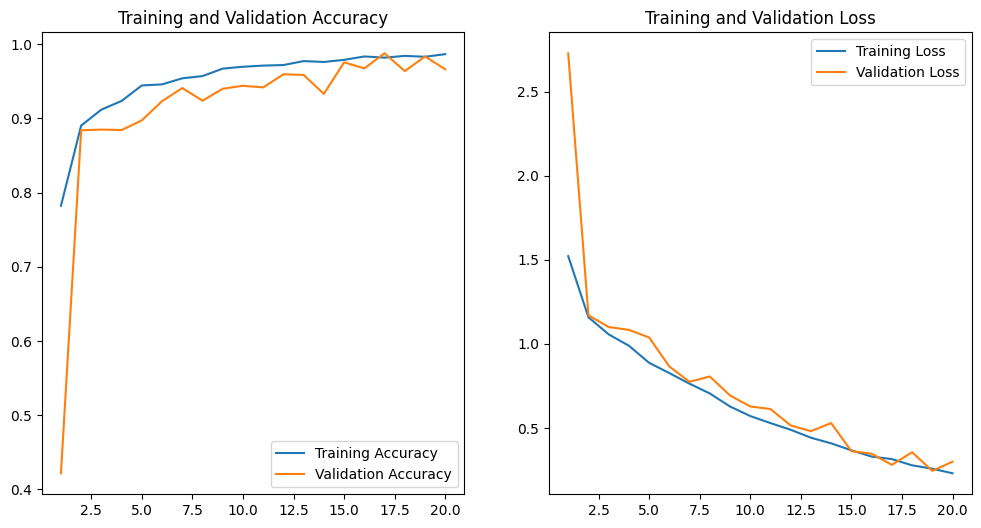

In [22]:
import matplotlib.pyplot as plt

# Assume history is the result of the model.fit call
# Example: history = model.fit(...)

# Extract the history data
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Display the plots
plt.show()


In [35]:
# data tacken from test set
import tensorflow as tf
import numpy as np

# Assuming img_height, img_width are defined as 224, 224 respectively

# Function to load and preprocess a single image
def load_and_preprocess_image_predict(image_path):
    image = tf.io.read_file(data_dir + '/' +image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [img_height, img_width])
    image = image / 255.0  # Normalize to [0, 1]
    return image

# Function to predict the class of a single image
def predict_image(model, image_path):
    image = load_and_preprocess_image_predict(image_path)
    image = tf.expand_dims(image, axis=0)  # Add batch dimension
    predictions = model.predict(image)
    predicted_class = np.argmax(predictions, axis=1)[0]
    return predicted_class

# # List of image paths for testing
test_image_paths = [
'100/252/2013/4/8e8610ccbf7265.jpg',
'100/252/2010/4/bb1864a60afbb5.jpg',
'102/254/2014/4/3952725c2141f7.jpg',
'102/255/2011/4/b638cf6bf16ba4.jpg',
'102/255/2010/4/e0e0b325bb8c35.jpg',
'102/255/2009/4/e2b8884cfb2450.jpg',
'102/256/2009/4/d8d8166ca55f26.jpg',
'102/256/2009/4/30551bf514df84.jpg',
'102/256/2011/4/437daf86f9c074.jpg',
'102/256/2009/4/bf0f7901e91a54.jpg',
'102/257/2013/4/54663992ab7af3.jpg',
'102/257/2013/4/9e7226108b3243.jpg',
'102/258/2014/4/acd19638b4c953.jpg',
'102/259/2013/4/7fbe5b1edae9d5.jpg',
'102/259/2012/4/e011754be3b51c.jpg',
'102/259/2010/4/098b741024567d.jpg',
'102/260/2010/4/adb2d1987187f7.jpg',
'102/261/2014/4/c7837f0996e0fa.jpg',
'102/261/2012/4/11de7d3192308d.jpg',
'84/1962/2011/5/55714e191f59ff.jpg',
'37/1983/2013/5/85d5bc70887100.jpg',
'37/1984/2013/5/25444c3b24e551.jpg',
'78/44/2013/2/090254afa69889.jpg',
'81/68/2008/2/47913df047a8db.jpg',
'81/68/2011/2/958cb72357f240.jpg',
'39/1386/2011/8/372dece0e404c4.jpg',
'39/1386/2013/8/1ba446fb104ca0.jpg',
'39/1387/2012/8/8f00cfe04af950.jpg',
'75/1671/2010/3/86ccc06f2660b5.jpg',
'75/1671/2010/3/fff04a49b661a4.jpg',
'75/1671/2012/3/67fe334ae82a5c.jpg',
'69/1487/2012/1/e0717e76410ef8.jpg',
'69/1487/2013/1/4f452af46c039d.jpg',
'69/1487/2013/1/e9089030b4adcd.jpg',
'111/1705/2015/7/9c1870f2cbb9c2.jpg',
'111/1705/2014/7/b1989f26fabc87.jpg',
'111/1706/2014/7/d59cd401b690a1.jpg',
'111/1706/2009/7/08db9136134a14.jpg',
'78/1/2014/8/0b4041d7e598c7.jpg',
'78/1/2014/8/a5f6d3298cc125.jpg',
'78/1/2012/8/d031065717fb52.jpg',
'78/1/2014/8/f8561ef154d441.jpg',
'78/1/2010/8/38d1f42051503b.jpg',
'78/1/2014/8/b160450e1f2ae6.jpg',
'78/2/2015/8/592fad0974c3b4.jpg',
'78/2/2010/8/02ce2d17c6f9e2.jpg',
'78/2/2012/8/627ec98b3f3513.jpg',
'162/1636/2013/6/ea059d337aa51d.jpg',
'162/1636/2012/6/3b6b30910f4335.jpg',
'162/1637/2014/6/3bee4590741ac4.jpg',
'162/1637/2014/6/9fdf0d82ca53e0.jpg',
'75/1652/2009/6/78fae7e9841d5b.jpg',
'75/1653/2013/6/de39f443f998fd.jpg',
    # Add more image paths
]
# 78/1/2014/1/fa6d0ee4f0bcde.jpg
# 78/1/2010/1/502daaaa4398c6.jpg
# 78/1/2010/1/c45f35af9bc066.jpg
# 78/1/2010/1/fc6fc7fb62fbb9.jpg
# 78/1/2014/1/bd0867deae93cb.jpg
# 78/1/2013/1/a607fd65d2bd93.jpg
# Load the trained model (adjust the model path as necessary)
# image_path = data_dir + '/142/1138/2014/5/6027c11ebde859.jpg'
model = tf.keras.models.load_model('/kaggle/working/resnet50_part_sparse_categorical_crossentropy.h5')

# predicted_class = predict_image(model, image_path)
# print(f"Image: {image_path}, Predicted class: {predicted_class + 1}")
mistake_counter = 0
# Predict and print the classes for the test images
for image_path in test_image_paths:
    print(image_path)
    predicted_class = predict_image(model, image_path)
    parts = image_path.split('/')
    true_lable=  int(parts[-2])
    print(f"Image: {image_path}, Predicted class: {predicted_class + 1}", ", True Lable: ", true_lable)
    if  true_lable != (predicted_class + 1):
        mistake_counter +=1
        
print('Total Imags to be predicted: ', len(test_image_paths))
print('Number of wrong pridection: ', mistake_counter)


100/252/2013/4/8e8610ccbf7265.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Image: 100/252/2013/4/8e8610ccbf7265.jpg, Predicted class: 4 , True Lable:  4
100/252/2010/4/bb1864a60afbb5.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Image: 100/252/2010/4/bb1864a60afbb5.jpg, Predicted class: 4 , True Lable:  4
102/254/2014/4/3952725c2141f7.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Image: 102/254/2014/4/3952725c2141f7.jpg, Predicted class: 4 , True Lable:  4
102/255/2011/4/b638cf6bf16ba4.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Image: 102/255/2011/4/b638cf6bf16ba4.jpg, Predicted class: 4 , True Lable:  4
102/255/2010/4/e0e0b325bb8c35.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Image: 102/255/2010/4/e0e0b325bb8c35.jpg, Predicted class: 4 , True Lable:  4
102/255/2009/4/e2b8884cfb2450.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Image: 102/255/2009/4/e2b8884cfb2450.jpg, Predicted class: 4 , True Lable:  4
102/256/2009/4/d8d8166ca55f26.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Image: 102/256/2009/4/d8d8166c